Die Bachelorarbeit beschäftigt sich mit inkompressiblen Strömungen, wie sie in einer Vielzahl in industriellen Anwendungen sowie umweltrelevanten Problemen auftreten. Dabei erfordert die Lösung der Navier-Stokes-Gleichungen einen erheblichen Zeit- und Rechenaufwand. Ziel der Arbeit ist es, mittels «echten» Simulationsergebnissen verschiedener Strömungsszenarien ein Deep Learning-Netz anzulernen, sodass für neue Szenarien (bspw. mit alternativen Geometrien, Randbedingungen oder Reynolds-Zahlen) die Ergebnisse durch das Netz vorhergesagt werden können. Zur Einordnung der damit erzielten Qualität sind die vorhergesagten Ergebnisse mit den gerechneten Ergebnissen aus einem Strömungscode zu vergleichen.
Dazu soll ebenfalls evaluiert werden, welche Szenarien, d.h. welche Änderungen (Geometrie, Randbedingungen, Strömungsparameter) sich besonders gut vorhersagen lassen und welche nicht.

### V1.01: Only 1 dummy image

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [26]:
def create_model(input_shape, num_outputs):
    # Define input layers
    image_input = layers.Input(shape=input_shape, name='image_input')
    reynolds_input = layers.Input(shape=(1,), name='reynolds_input')

    # Image branch
    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Combine image and reynolds inputs
    combined_input = layers.concatenate([x, reynolds_input])

    # Output layers
    outputs = []
    for i in range(num_outputs):
        outputs.append(layers.Dense(64*64, activation='sigmoid', name=f'output_{i}')(combined_input))

    # Reshape outputs to image size
    reshaped_outputs = [layers.Reshape((64, 64, 1), name=f'reshaped_output_{i}')(output) for i, output in enumerate(outputs)]

    # Define model
    model = models.Model(inputs=[image_input, reynolds_input], outputs=reshaped_outputs)
    return model

In [27]:
# Generate dummy data
num_samples = 1000
image_shape = (64, 64, 3)
input_reynolds = np.random.uniform(1, 1000, size=(num_samples, 1))
input_images = np.random.rand(num_samples, *image_shape)

# Generate dummy output data
num_outputs = 3
output_data = [np.random.rand(num_samples, 64, 64, 1) for _ in range(num_outputs)]

# Create and compile the model
model = create_model(image_shape, num_outputs)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit([input_images, input_reynolds], output_data, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


SystemError: \Objects\listobject.c:337: bad argument to internal function

In [ ]:
# Function to plot input image and predicted flow scenario
def plot_input_and_prediction(input_image, predicted_flow_scenario):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot input image
    axes[0].imshow(input_image)
    axes[0].set_title('Input Image')

    # Plot predicted flow scenario
    for i, prediction in enumerate(predicted_flow_scenario):
        axes[1].imshow(prediction.squeeze(), cmap='jet', alpha=0.5, label=f'Prediction {i+1}')
    axes[1].set_title('Predicted Flow Scenario')
    axes[1].legend()

    plt.show()


In [ ]:
new_reynolds_number = np.array([[500]])
new_image = np.random.rand(1, *image_shape)
predicted_flow_scenario = model.predict([new_image, new_reynolds_number])
plot_input_and_prediction(new_image.squeeze(), predicted_flow_scenario)

### v1.02: with 3 dummy images (for pressure, $u_{vel}$ and $v_{vel}$)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a multi-input, multi-output CNN model
def create_model(input_shape, num_outputs):
    # Define input layers
    pressure_input = layers.Input(shape=input_shape, name='pressure_input')
    u_velocity_input = layers.Input(shape=input_shape, name='u_velocity_input')
    v_velocity_input = layers.Input(shape=input_shape, name='v_velocity_input')
    reynolds_input = layers.Input(shape=(1,), name='reynolds_input')

    # Stack input layers
    reynolds_input_reshaped = layers.Reshape((1, 1, 1))(reynolds_input)
    reynolds_input_tiled = layers.UpSampling2D(size=(input_shape[0], input_shape[1]))(reynolds_input_reshaped)

    combined_input = layers.concatenate([pressure_input, u_velocity_input, v_velocity_input, reynolds_input_tiled], axis=-1)

    # Common CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(combined_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output layers
    outputs = []
    for i in range(num_outputs):
        outputs.append(layers.Dense(64*64, activation='sigmoid', name=f'output_{i}')(x))

    print(input_shape)
    # Reshape outputs to image size
    reshaped_outputs = [layers.Reshape((128, 128, 1), name=f'reshaped_output_{i}')(output) for i, output in enumerate(outputs)]

    # Define model
    model = models.Model(inputs=[pressure_input, u_velocity_input, v_velocity_input, reynolds_input], outputs=reshaped_outputs)
    return model

# Generate dummy data
num_samples = 1000
image_shape = (128, 128, 1)  # assuming grayscale images
input_reynolds = np.random.uniform(1, 1000, size=(num_samples, 1))
input_pressure = np.random.rand(num_samples, *image_shape)
input_u_velocity = np.random.rand(num_samples, *image_shape)
input_v_velocity = np.random.rand(num_samples, *image_shape)

# Generate dummy output data
num_outputs = 3
output_data = [np.random.rand(num_samples, *image_shape) for _ in range(num_outputs)]

# Create and compile the model
model = create_model(image_shape, num_outputs)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit([input_pressure, input_u_velocity, input_v_velocity, input_reynolds], [input_pressure, input_u_velocity, input_v_velocity], epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
import matplotlib.pyplot as plt

# Function to plot input images and predicted flow scenarios
def plot_input_and_predictions(input_images, predicted_flow_scenarios):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot input images
    titles = ['Pressure', 'U Velocity', 'V Velocity']
    for i in range(len(input_images)):
        axes[0, i].imshow(input_images[i].squeeze(), cmap='jet')
        axes[0, i].set_title(titles[i])
        axes[0, i].axis('off')

    # Plot predicted flow scenarios
    for i, predicted_flow_scenario in enumerate(predicted_flow_scenarios):
        axes[1, i].imshow(predicted_flow_scenario.squeeze(), cmap='jet')
        axes[1, i].set_title(f'Predicted {titles[i]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:

# Example usage for prediction
new_reynolds_number = np.array([[100]])
new_pressure = np.random.rand(1, *image_shape)
new_u_velocity = np.random.rand(1, *image_shape)
new_v_velocity = np.random.rand(1, *image_shape)

predicted_flow_scenario = model.predict([new_pressure, new_u_velocity, new_v_velocity, new_reynolds_number])
input_images = [new_pressure, new_u_velocity, new_v_velocity]
plot_input_and_predictions(input_images, predicted_flow_scenario)

#### real data

In [ ]:
from PIL import Image
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
def create_model(input_shape, num_outputs):
    # Define input layers
    pressure_input = layers.Input(shape=input_shape, name='pressure_input')
    u_velocity_input = layers.Input(shape=input_shape, name='u_velocity_input')
    v_velocity_input = layers.Input(shape=input_shape, name='v_velocity_input')
    reynolds_input = layers.Input(shape=(1,), name='reynolds_input')

    # Stack input layers
    reynolds_input_reshaped = layers.Reshape((1, 1, 1))(reynolds_input)
    reynolds_input_tiled = layers.UpSampling2D(size=(input_shape[0], input_shape[1]))(reynolds_input_reshaped)

    combined_input = layers.concatenate([pressure_input, u_velocity_input, v_velocity_input, reynolds_input_tiled], axis=-1)

    # Common CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(combined_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output layers
    outputs = []
    for i in range(num_outputs):
        outputs.append(layers.Dense(input_shape[0]*input_shape[1], activation='sigmoid', name=f'output_{i}')(x))

    # Reshape outputs to image size
    reshaped_outputs = [layers.Reshape((input_shape[0], input_shape[1], 1), name=f'reshaped_output_{i}')(output) for i, output in enumerate(outputs)]

    # Define model
    model = models.Model(inputs=[pressure_input, u_velocity_input, v_velocity_input, reynolds_input], outputs=reshaped_outputs)
    return model

In [ ]:
RE = 100.0
path = f'data/{RE}'
image_shape = (128, 128, 4)
input_pressure = []
input_u_velocity = []
input_v_velocity = []
for x in np.arange(0, 10, 0.05):
    input_pressure.append(np.array(Image.open(f'{path}/p_{x:.2f}.png')))
    input_u_velocity.append(np.array(Image.open(f'{path}/u_{x:.2f}.png')))
    input_v_velocity.append(np.array(Image.open(f'{path}/v_{x:.2f}.png')))
input_pressure = np.array(input_pressure)
input_u_velocity = np.array(input_u_velocity)
input_v_velocity = np.array(input_v_velocity)
num_samples = len(input_pressure)
input_reynolds = [RE] * num_samples
input_reynolds = np.array(input_reynolds).reshape(num_samples, 1)
num_samples

200

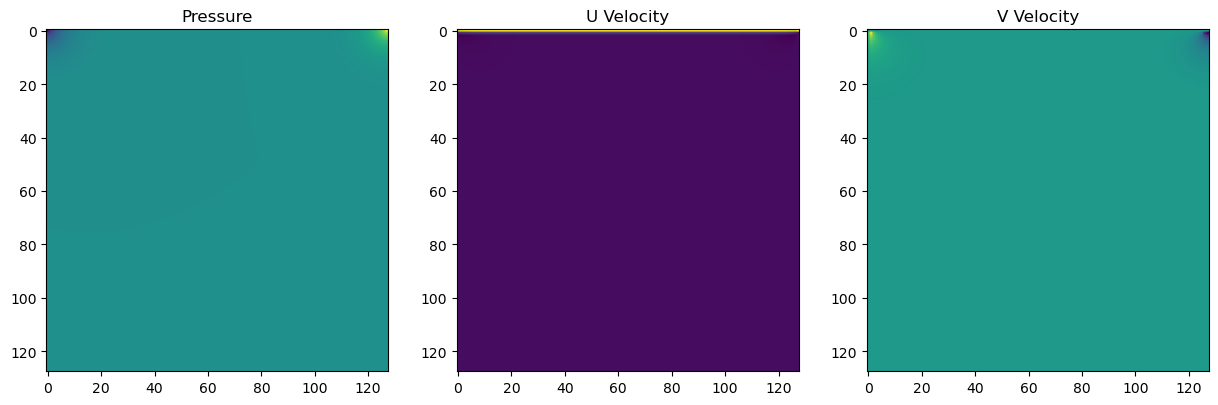

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(input_pressure[0])
axes[0].set_title('Pressure')
axes[1].imshow(input_u_velocity[0])
axes[1].set_title('U Velocity')
axes[2].imshow(input_v_velocity[0])
axes[2].set_title('V Velocity')
plt.show()

In [ ]:
output_data = [input_pressure, input_u_velocity, input_v_velocity]
num_outputs = len(output_data)

# Create and compile the model
model = create_model(image_shape, num_outputs)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit([input_pressure, input_u_velocity, input_v_velocity, input_reynolds], output_data, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 76650.5781 - val_loss: 76947.6328
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 76453.6172 - val_loss: 76884.2891
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 76430.0078 - val_loss: 76860.8516
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 76379.6172 - val_loss: 76848.6797
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 76423.2578 - val_loss: 76842.2812
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 76346.3672 - val_loss: 76839.6562
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 76387.2109 - val_loss: 76838.0391
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 76384.2969 - val_loss: 76836.3828
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 76391.8516 - val_loss: 76835.0781
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 76406.9375 - val_loss: 76833.6328


In [ ]:
import matplotlib.pyplot as plt

# Function to plot input images and predicted flow scenarios
def plot_input_and_predictions(input_images, predicted_flow_scenarios):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot input images
    titles = ['Pressure', 'U Velocity', 'V Velocity']
    for i in range(len(input_images)):
        axes[0, i].imshow(input_images[i].squeeze(), cmap='jet')
        axes[0, i].set_title(titles[i])
        axes[0, i].axis('off')

    # Plot predicted flow scenarios
    for i, predicted_flow_scenario in enumerate(predicted_flow_scenarios):
        axes[1, i].imshow(predicted_flow_scenario.squeeze(), cmap='jet')
        axes[1, i].set_title(f'Predicted {titles[i]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [97]:
# Example usage for prediction
new_reynolds_number = np.array([[100]])
new_pressure = input_pressure[100].reshape(1, *image_shape)
new_u_velocity = input_u_velocity[100].reshape(1, *image_shape)
new_v_velocity = input_v_velocity[100].reshape(1, *image_shape)

predicted_flow_scenario = model.predict([new_pressure, new_u_velocity, new_v_velocity, new_reynolds_number])
input_images = [new_pressure, new_u_velocity, new_v_velocity]
plot_input_and_predictions(input_images, predicted_flow_scenario)

AttributeError: 'LidDrivenCavityModel' object has no attribute 'predict'

### multi RE

In [1]:
from PIL import Image
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def create_model(input_shape, num_outputs):
    # Define input layers
    pressure_input = layers.Input(shape=input_shape, name='pressure_input')
    u_velocity_input = layers.Input(shape=input_shape, name='u_velocity_input')
    v_velocity_input = layers.Input(shape=input_shape, name='v_velocity_input')
    reynolds_input = layers.Input(shape=(1,), name='reynolds_input')

    # Stack input layers
    reynolds_input_reshaped = layers.Reshape((1, 1, 1))(reynolds_input)
    reynolds_input_tiled = layers.UpSampling2D(size=(input_shape[0], input_shape[1]))(reynolds_input_reshaped)

    combined_input = layers.concatenate([pressure_input, u_velocity_input, v_velocity_input, reynolds_input_tiled], axis=-1)

    # Common CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(combined_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output layers
    outputs = []
    for i in range(num_outputs):
        outputs.append(layers.Dense(input_shape[0]*input_shape[1], activation='sigmoid', name=f'output_{i}')(x))

    # Reshape outputs to image size
    reshaped_outputs = [layers.Reshape((input_shape[0], input_shape[1], 1), name=f'reshaped_output_{i}')(output) for i, output in enumerate(outputs)]

    # Define model
    model = models.Model(inputs=[pressure_input, u_velocity_input, v_velocity_input, reynolds_input], outputs=reshaped_outputs)
    return model

In [3]:
REs = np.arange(100., 1000., 5.)
paths = [f'data/{RE}' for RE in REs]
image_shape = (128, 128, 4)
input_pressure = []
input_u_velocity = []
input_v_velocity = []
input_reynolds = []

In [4]:
with tqdm(total=len(paths)) as pbar:
    for i, path in enumerate(paths):
        for x in np.arange(0.05, 10, 0.05):
            input_pressure.append(np.array(Image.open(f'{path}/p_{x:.2f}.png')))
            input_u_velocity.append(np.array(Image.open(f'{path}/u_{x:.2f}.png')))
            input_v_velocity.append(np.array(Image.open(f'{path}/v_{x:.2f}.png')))
            input_reynolds.append([REs[i]])
        pbar.update(1)
        pbar.set_description(f'Processed t:{REs[i]:.2f}, total samples:{len(input_pressure):3d}')
input_pressure = np.array(input_pressure)
input_u_velocity = np.array(input_u_velocity)
input_v_velocity = np.array(input_v_velocity)
input_reynolds = np.array(input_reynolds)

num_samples = len(input_pressure)
num_samples

100%|██████████| 180/180 [05:25<00:00,  1.81s/it]


35820

In [10]:
output_data = [input_pressure, input_u_velocity, input_v_velocity]
num_outputs = len(output_data)

# Create and compile the model
model = create_model(image_shape, num_outputs)
# use l1 loss
model.compile(optimizer='adam', loss='mse')

epochs = 15
batch_size = 64

# Train the model
history = model.fit([input_pressure, input_u_velocity, input_v_velocity, input_reynolds], output_data, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 161s 353ms/step - loss: 77233.5938 - val_loss: 76839.0391
Epoch 2/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 152s 340ms/step - loss: 77214.1562 - val_loss: 76839.0391
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 140s 312ms/step - loss: 77214.9219 - val_loss: 76839.0391
Epoch 4/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 150s 334ms/step - loss: 77220.3125 - val_loss: 76839.0391
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 161s 359ms/step - loss: 77218.9531 - val_loss: 76839.0391
Epoch 6/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 155s 346ms/step - loss: 77206.6406 - val_loss: 76839.0391
Epoch 7/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 154s 345ms/step - loss: 77207.5547 - val_loss: 76839.0391
Epoch 8/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 154s 344ms/step - loss: 77213.9219 - val_loss: 76839.0391
Epoch 9/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 152s 340ms/step - loss: 77213.6562 - val_loss: 76839.0391
Epoch 10/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 153s 340ms/step - loss: 77208.9766 - val_loss: 76839.0391
Epoch 11/15
448/448

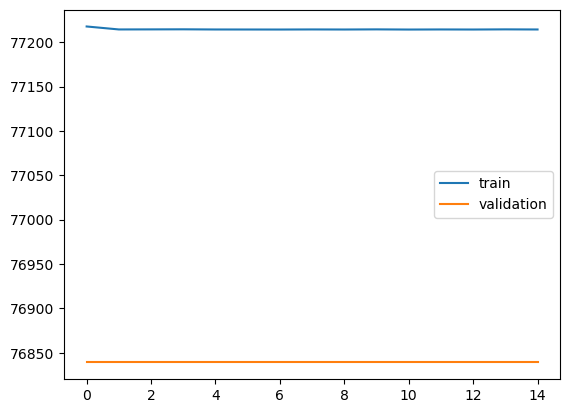

In [11]:
# plot the history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [12]:
import matplotlib.pyplot as plt

# Function to plot input images and predicted flow scenarios
def plot_input_and_predictions(input_images, predicted_flow_scenarios):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot input images
    titles = ['Pressure', 'U Velocity', 'V Velocity']
    for i in range(len(input_images)):
        axes[0, i].imshow(input_images[i].squeeze(), cmap='jet')
        axes[0, i].set_title(titles[i])
        axes[0, i].axis('off')

    # Plot predicted flow scenarios
    for i, predicted_flow_scenario in enumerate(predicted_flow_scenarios):
        axes[1, i].imshow(predicted_flow_scenario.squeeze(), cmap='jet')
        axes[1, i].set_title(f'Predicted {titles[i]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


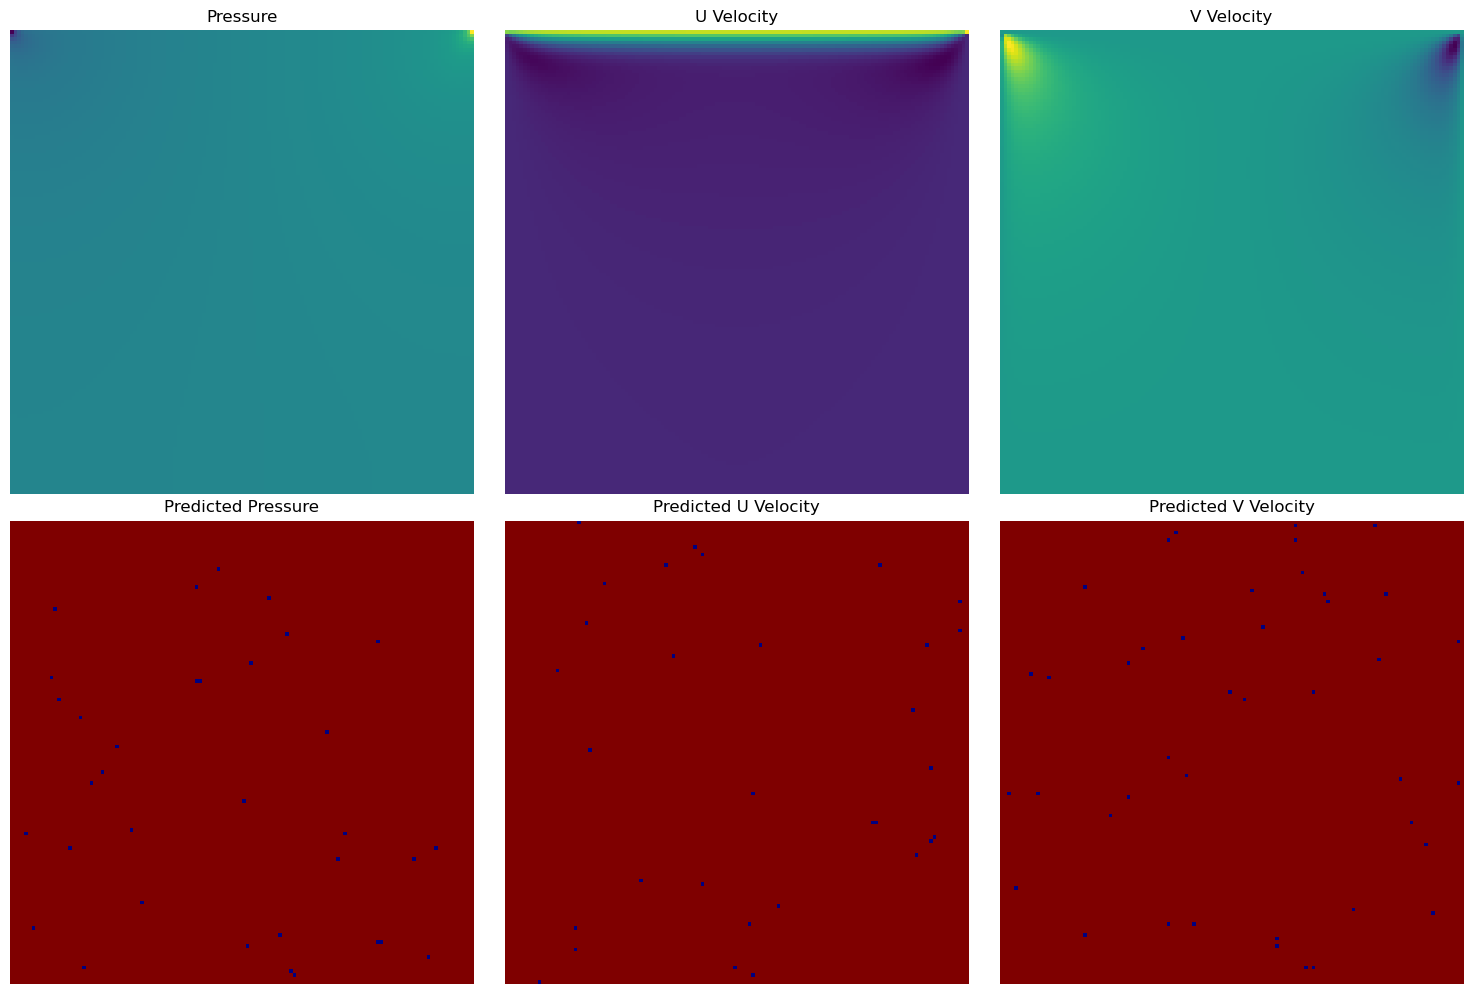

In [13]:
# Example usage for prediction
new_reynolds_number = np.array([[100]])
new_pressure = input_pressure[0].reshape(1, *image_shape)
new_u_velocity = input_u_velocity[0].reshape(1, *image_shape)
new_v_velocity = input_v_velocity[0].reshape(1, *image_shape)

predicted_flow_scenario = model.predict([new_pressure, new_u_velocity, new_v_velocity, new_reynolds_number])
input_images = [new_pressure, new_u_velocity, new_v_velocity]
plot_input_and_predictions(input_images, predicted_flow_scenario)